#Entrenamiento de una MLP con NumPy (sin frameworks)
En este ejemplo entrenamos una red neuronal multicapa empleando únicamente ***NumPy***. El modelo aprende a clasificar imágenes del conjunto ***MNIST***, formado por ***60.000*** dígitos manuscritos para entrenamiento y ***10.000*** para prueba, cada uno representado como una imagen en escala de grises de ***28×28 píxeles***. Implementamos manualmente todas las fases del aprendizaje supervisado: el paso hacia delante que genera la predicción, el cálculo de la pérdida que mide el error y la retropropagación que ajusta los pesos mediante descenso de gradiente. Esto permite entender con total claridad cómo funciona internamente una ***MLP*** al resolver un problema real de visión artificial sin depender de librerías de alto nivel.

## Funciones de activación y pérdida
Las funciones de activación aportan la no linealidad necesaria para que la red pueda aprender patrones complejos, mientras que la función de pérdida mide el error de la predicción y genera la señal que se retropropaga para ajustar los pesos. Sin activaciones, la red no podría representar relaciones reales; sin pérdida, no tendría forma de mejorar.

In [2]:
import numpy as np


# ===== FUNCIONES DE ACTIVACIÓN =====

def relu(x):
    # ReLU deja valores positivos tal cual y convierte en 0 los negativos
    # Introduce no linealidad, necesario para que la red aprenda patrones complejos
    return np.maximum(0, x)

def relu_deriv(x):
    # Derivada de ReLU (para backpropagation)
    # Si x > 0 -> gradiente = 1
    # Si x ≤ 0 -> gradiente = 0
    # Para que solo las neuronas activas transmitan el gradiente
    return (x > 0).astype(float)


# SOFTMAX
def softmax(x):
    # Softmax convierte los logits en probabilidades.
    # Restar el valor máximo evita overflow y hace la operación numéricamente estable
    e = np.exp(x - np.max(x))
    return e / np.sum(e) # Normalizamos para que la suma sea 1


# FUNCIÓN DE PÉRDIDA (CROSS ENTROPY)
def cross_entropy(pred, label):
    # Cross-entropy mide cuánto se aleja la predicción de la clase correcta
    # Penaliza fuertemente cuando la probabilidad asignada es baja
    return -np.log(pred[label] + 1e-9) # Se añade un pequeño valor para evitar log(0)

## Clase MNIST (forward y backward)
Creamos una clase para la ***MLP*** porque nos permite organizar bien el modelo. Entre otras cosas, guardar los pesos y sesgos, almacenar las activaciones intermedias del forward que luego necesita el backward, y separar claramente la lógica de predicción de la lógica de aprendizaje. De este modo el código es más limpio, reutilizable y se parece a cómo funcionan los modelos en frameworks como PyTorch o TensorFlow.



In [3]:
# ===== CLASE MLP =====
class MLP:

    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10):

        # Matriz de pesos de la capa oculta (784 -> 128) con inicialización He (ideal para ReLU)
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2 / input_dim)
        self.b1 = np.zeros(hidden_dim)

        # Matriz de pesos de la capa salida (128 -> 10)
        self.W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2 / hidden_dim)
        self.b2 = np.zeros(output_dim)


## Forward PASS (feed-forward)
Es la fase en la que la red neuronal toma una entrada y la transforma capa a capa hasta producir una predicción.
En este paso solo se realizan operaciones hacia delante: multiplicaciones por pesos, suma de sesgos y activaciones. No se calculan gradientes.


In [ ]:
    # ===== FORWARD PASS =====
    def forward(self, x):

      # Guardamos la entrada para usarla luego en backprop
      self.x = x

      # ----- Capa oculta -----
      # z1 = combinación lineal: entrada · pesos + sesgo
      self.z1 = x @ self.W1 + self.b1

      # a1: aplicamos ReLU → introducimos no linealidad
      self.a1 = relu(self.z1)

      # ----- Capa de salida -----
      # z2: creamos logits (otra transformación lineal)
      self.z2 = self.a1 @ self.W2 + self.b2

      # probs = distribución de probabilidad sobre las 10 clases
      self.probs = softmax(self.z2)

      # Devolvemos las probabilidades finales (una por cada clase 0–9)
      return self.probs

## Backward PASS
El método backward calcula cómo varía la pérdida respecto a cada peso de la red. Primero obtiene el error en la salida comparando la predicción con la etiqueta real y, a partir de ese error, aplica la regla de la cadena hacia atrás (***backpropagation***) para distribuir ese error por cada capa. Con los gradientes resultantes actualiza los pesos y sesgos, de forma que en la siguiente iteración la red reduzca su pérdida.


In [ ]:
    # ===== BACKWARD PASS =====
    # Comparamos la predicción con la etiqueta real para obtener el error que propagamos hacia atrás

    def backward(self, label, lr=0.01):
      # Derivada de softmax + cross-entropy: probabilidad predicha - etiqueta real(one-hot)
      dlogits = self.probs.copy() # Copia probabilidades predichas modelo
      dlogits[label] -= 1   # derivada exacta de la pérdida respecto a los logits

      # ----- Gradientes capa 2 -----
      # cada peso se ajusta según la activación previa y el error de salida
      dW2 = np.outer(self.a1, dlogits)
      db2 = dlogits                      # obtiene gradiente del sesgo

      # Propagamos el error hacia la capa oculta.
      # Multiplicamos por W2.T porque cada neurona oculta debe recibir
      # la parte del error que le corresponde según su contribución a la salida.
      da1 = dlogits @ self.W2.T

      # Filtramos el gradiente con la derivada de ReLU
      # ReLU solo deja pasar gradiente por neuronas activas
      dz1 = da1 * relu_deriv(self.z1)

      # ----- Gradientes capa 1 -----
      dW1 = np.outer(self.x, dz1)        # cada peso depende de la entrada y el error oculto
      db1 = dz1                          # el sesgo recibe el mismo gradiente

      # ----- Actualización SGD -----

      # Actualización con SGD: restamos lr * gradiente para reducir la pérdida
      self.W2 -= lr * dW2
      self.b2 -= lr * db2

      self.W1 -= lr * dW1
      self.b1 -= lr * db1

      # Devolvemos la pérdida (para monitorizar entrenamiento)
      return cross_entropy(self.probs, label)

## Cargamos MNIST y normalizamos
Antes de entrenar la red necesitamos cargar el dataset MNIST y preparar los datos. Cada imagen se convierte en un vector de 784 valores y se normaliza dividiendo entre 255 para que todos los píxeles queden en el rango 0,1. Esto facilita el entrenamiento y evita problemas numéricos. También cargamos las etiquetas asociadas a cada imagen para poder calcular la pérdida y evaluar el modelo.


In [4]:
# ===== CARGA DE MNIST =====
def load_mnist(path="mnist.npz"):
    data = np.load(path)

    # Normalizamos a [0,1] y aplanamos cada imagen a un vector de 784 píxeles
    x_train = data["x_train"].reshape(-1, 28*28) / 255.0
    y_train = data["y_train"]

     # Igual para el conjunto de test
    x_test = data["x_test"].reshape(-1, 28*28) / 255.0
    y_test = data["y_test"]

    return x_train, y_train, x_test, y_test

## Entrenamiento del modelo

In [5]:
# ===== CONFIGURACIÓN ENTRENO =====
if __name__ == "__main__":

    # Cargamos datos
    x_train, y_train, x_test, y_test = load_mnist()

    model = MLP()
    lr = 0.01
    epochs = 5

    # Variables de las métricas para luego dibujar la gráfica
    loss_history = []
    acc_history = []

In [6]:
    # ===== ENTRENAMIENTO =====

    # Entrenamiento con SGD (una muestra cada vez)
    for epoch in range(epochs):

        total_loss = 0     # acumulamos la pérdida para ver si baja
        correct = 0        # contador de aciertos

        # Recorremos todas las imágenes del entrenamiento
        for i in range(len(x_train)):
            x = x_train[i]    # imagen aplanada
            y = y_train[i]    # etiqueta verdadera

            probs = model.forward(x)     # predicción
            loss = model.backward(y, lr) # ajustamos pesos

            total_loss += loss           # acumulamos pérdida

            # Si la clase con mayor probabilidad coincide con la verdadera -> acierto
            if np.argmax(probs) == y:
                correct += 1

        # Métricas por época
        print(
            f"Epoch {epoch+1}: "
            f"loss {(total_loss/len(x_train)):.4f}, "
            f"acc {correct/len(x_train):.3f}"
        )
        # Añado total_loss(suma de todas las pérdidas de esa epoch)
        # Añado aciertos (número de predicciones correctas)
        loss_history.append(total_loss / len(x_train))
        acc_history.append(correct / len(x_train))

Epoch 1: loss 0.2120, acc 0.937
Epoch 2: loss 0.0946, acc 0.972
Epoch 3: loss 0.0652, acc 0.980
Epoch 4: loss 0.0480, acc 0.986
Epoch 5: loss 0.0362, acc 0.990


## TEST

In [ ]:
 # ================================
    #  TEST
    # ================================
    correct_test = 0

    # Solo hacemos forward, no se actualizan pesos
    for i in range(len(x_test)):
        probs = model.forward(x_test[i])

        # np.argmax = clase con mayor probabilidad
        if np.argmax(probs) == y_test[i]:
            correct_test += 1

    print(f"Test accuracy: {correct_test/len(x_test):.3f}")

## Gráfica

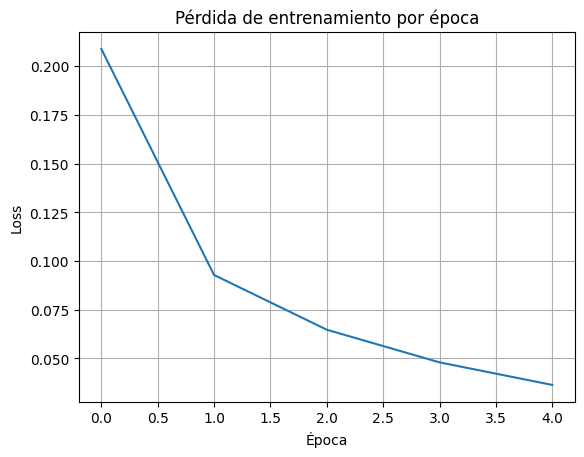

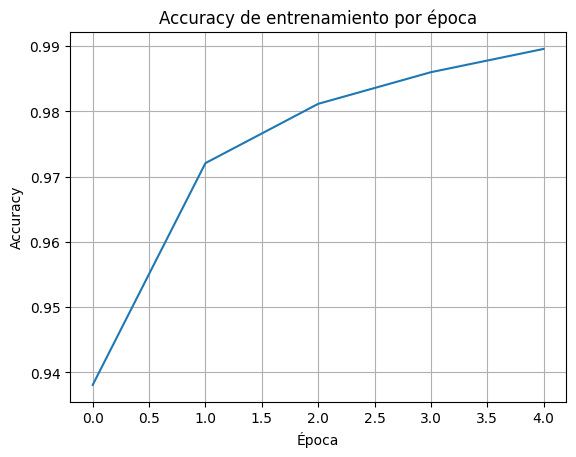

In [19]:
import matplotlib.pyplot as plt

# Dibujamos la gráfica de la pérdida
plt.plot(loss_history)
plt.title("Pérdida de entrenamiento por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid()
plt.show()

# Dibujamos la gráfica de la
plt.plot(acc_history)
plt.title("Accuracy de entrenamiento por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

# Test del modelo

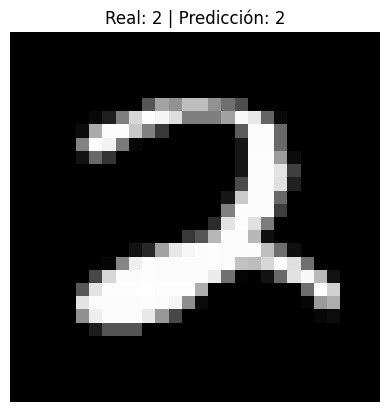

Probabilidades softmax: [1.03688621e-07 5.08864169e-06 9.99990430e-01 5.60084107e-07
 6.20981016e-08 1.60079259e-06 8.48110615e-09 8.99784501e-07
 1.24550631e-06 1.06799475e-09]


In [27]:
import matplotlib.pyplot as plt

# ===== PRUEBA VISUAL =====
id = 888  # elige cualquier índice del test

img = x_test[id].reshape(28, 28)
label_real = y_test[id]

# Predicción del modelo
probs = model.forward(x_test[id])
pred = np.argmax(probs)

# Mostrar imagen + resultados
plt.imshow(img, cmap="gray")
plt.title(f"Real: {label_real} | Predicción: {pred}")
plt.axis("off")
plt.show()

# Imprimir probabilidades (opcional)
print("Probabilidades softmax:", probs)